In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


# Load the dataset
df = pd.read_csv('music_genre.csv')

# Display the first few rows of the dataset
#print('First rows: \n', df.head())

# a. Attribute types and their semantics
attribute_types = df.dtypes
semantics = df.describe(include='all')
#print('Attribute Types: \n',  attribute_types)
#print('Semantics: \n', semantics)

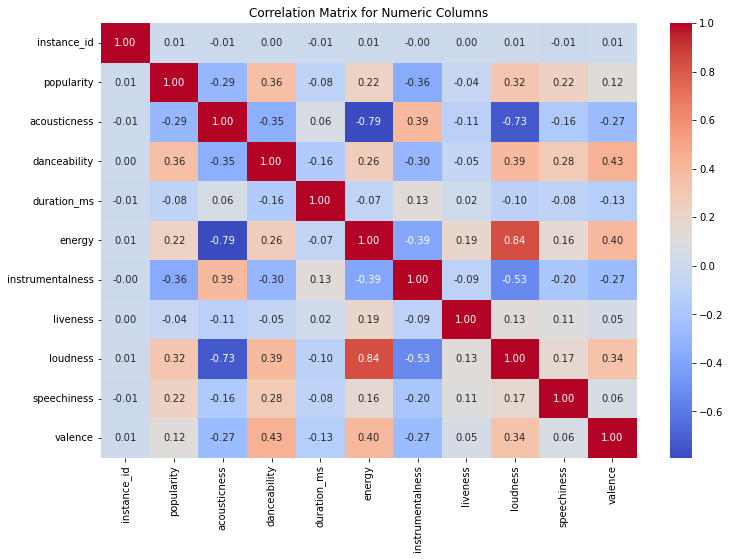

In [9]:
# b. Statistical properties and correlations
# Select only numeric columns
numeric_columns = df.select_dtypes(include=[np.number])

# Display correlation matrix for numeric columns
correlations_numeric = numeric_columns.corr()

# Visualize correlations using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlations_numeric, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Numeric Columns')
plt.savefig('correlation_matrix.png')
plt.show()


Missing values: 
 instance_id         5
artist_name         5
track_name          5
popularity          5
acousticness        5
danceability        5
duration_ms         5
energy              5
instrumentalness    5
key                 5
liveness            5
loudness            5
mode                5
speechiness         5
tempo               5
obtained_date       5
valence             5
music_genre         5
dtype: int64


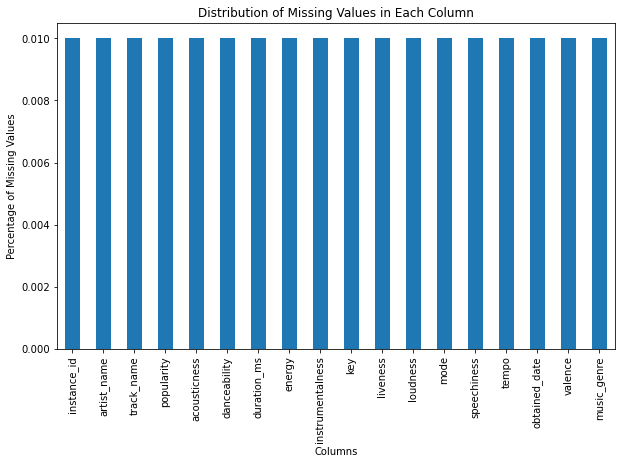

In [10]:
# c. Data quality aspects
missing_values = df.isnull().sum()
data_distribution = df['music_genre'].value_counts()
print( 'Missing values: \n', missing_values)
# Calculate the percentage of missing values for each column
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Plot the distribution of missing values
plt.figure(figsize=(10, 6))
missing_percentage.plot(kind='bar')
plt.title('Distribution of Missing Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.savefig('distribution_missing_values.png')
plt.show()


In [1]:
# d. Visual exploration of data properties and hypotheses
# Visualize correlations using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlations_numeric, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

NameError: name 'plt' is not defined

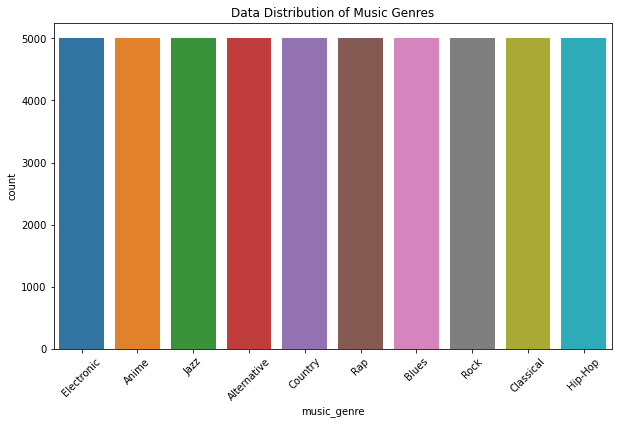

In [12]:
# Visualize data distribution of the target variable
plt.figure(figsize=(10, 6))
sns.countplot(x='music_genre', data=df)
plt.title('Data Distribution of Music Genres')
plt.xticks(rotation=45)
plt.savefig('data_distribution_music_genres.png')
plt.show()


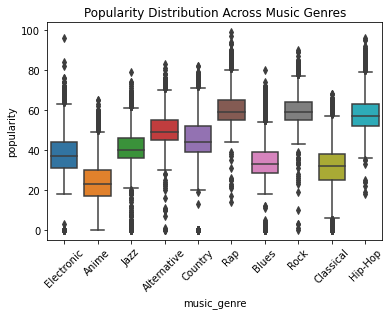

In [13]:
# e. Evaluate potentially ethically sensitive attributes and unbalanced distributions
# You may want to explore the distribution of other attributes based on the target variable, e.g., 'popularity' by 'music_genre'
sns.boxplot(x='music_genre', y='popularity', data=df)
plt.title('Popularity Distribution Across Music Genres')
plt.xticks(rotation=45)
plt.show()

In [14]:
# f. Potential risks and biases
# It's important to consult domain experts for understanding biases related to music genres.
# For example, consider biases related to cultural factors, language, or geographical regions.

# g. Actions likely required in data preparation
# Address missing values, handle outliers, and consider oversampling or undersampling for imbalanced classes.

In [15]:
# Assuming you have performed oversampling and undersampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Assuming 'music_genre' is the target variable
X = df_cleaned.drop('music_genre', axis=1)
y = df_cleaned['music_genre']

# Oversampling
ros = RandomOverSampler()
X_oversampled, y_oversampled = ros.fit_resample(X, y)

# Undersampling
rus = RandomUnderSampler()
X_undersampled, y_undersampled = rus.fit_resample(X, y)

# Plot class distribution before and after oversampling and undersampling
plt.figure(figsize=(15, 6))

# Plot original class distribution
plt.subplot(1, 3, 1)
sns.countplot(x='music_genre', data=df)
plt.title('Original Class Distribution')
plt.xticks(rotation=45)

# Plot oversampled class distribution
plt.subplot(1, 3, 2)
sns.countplot(x=y_oversampled)
plt.title('Oversampled Class Distribution')
plt.xticks(rotation=45)

# Plot undersampled class distribution
plt.subplot(1, 3, 3)
sns.countplot(x=y_undersampled)
plt.title('Undersampled Class Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'imblearn'

In [16]:
# 3.a Analyze and perform necessary actions based on analysis performed in the Data Understanding phase.
numerical_attributes = ['popularity' , 'acousticness', 'danceability', 'duration_ms', 'energy', 
                            'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


    # 3.a.1 set attribute tempo to float (already done for task d)
df = pd.read_csv('music_genre.csv')
df['tempo'] = pd.to_numeric(df['tempo'], errors='coerce')  # 'coerce' will turn non-numeric values to NaN

    # 3.a.2 Clean missing values (task a)
df_cleaned = df.dropna()

    # 3.a.3 Remove the instance id (task a)
df_cleaned = df_cleaned.drop(columns=['instance_id'])

    # 3.a.4 filter out duration of -1 (4.340 rows) (already done for task d)
df_cleaned = df_cleaned[df_cleaned['duration_ms'] != -1.0]


    # 3.a.5 Analyze outliers and remove them if needed (done on numerical attributes) (task a)
for attribute in numerical_attributes:
   q_low = df_cleaned[attribute].quantile(0.01)
   q_high = df_cleaned[attribute].quantile(0.99)
   df_cleaned_outliers = df_cleaned[(df_cleaned[attribute] > q_low) & (df_cleaned[attribute] < q_high)]

    # 3.a.6 #filter out artist "empty_field" (1.934 rows) (already done for task d)
df_cleaned_outliers = df_cleaned_outliers[df_cleaned_outliers['artist_name'] != 'empty_field']


    # 3.a.7 Check if the same artist has songs for more than two genres (3.166 rows) (task a)
artist_genre_counts = df_cleaned_outliers.groupby('artist_name')['music_genre'].nunique()
artists_with_multiple_genres = artist_genre_counts[artist_genre_counts > 2].index.tolist()

for artist in artists_with_multiple_genres:
    df_cleaned_outliers = df_cleaned_outliers[df_cleaned_outliers['artist_name'] != artist]

# Consider the correlated attributes during the preprocessing (task a, but is done during task b)
print('filtered rows:')
print(len(df)-len(df_cleaned_outliers))

filtered rows:
15268


In [19]:
# 3.b Analyze options and potential for derived attributes (note: if the potential is considered low, 
#these obviously do not necessarily have to be applied for your analysis, but options should be documented)

# 3.b.1 Feature Scaling (for numerical data)
    # Example: Scaling numerical features to a standard range (e.g., Min-Max scaling).
    # Potential: Ensures that features contribute equally to the model and improves convergence.

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_derrived = df_cleaned_outliers.copy()
df_derrived[numerical_attributes] = scaler.fit_transform(df_derrived[numerical_attributes])

# 3.b.2 Consider correlated attributes during preprocessing
    # Attribute creation
    # Example: Combining two or more features to create an interaction term (e.g., loudness * energy).
    # Potential: Captures relationships between features that may have a combined effect on the target variable.

corr_matrix = df_cleaned_outliers.corr().abs()
most_correlated_pairs = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
                    k=1).astype(bool)).stack().sort_values(ascending=False)).head(3).reset_index()

df_derrived = df_derrived.copy()
correlated_attributes = []

for index, row in most_correlated_pairs.iterrows():
    new_column_name = f"{row['level_0']}_{row['level_1']}_interaction"
    correlated_attributes.append(new_column_name)
    df_derrived[new_column_name] = df_derrived[row['level_0']] * df_derrived[row['level_1']]


df_derrived[correlated_attributes] = scaler.fit_transform(df_derrived[correlated_attributes])



# 3.b.3 Categorical Feature Encoding:
    # Example: One-hot encoding categorical variables (e.g., genre) to convert them into numerical format.
    # Potential: Enables the use of categorical data in machine learning models

categorical_features = ['key', 'mode', 'music_genre']  
df_derrived = pd.get_dummies(df_derrived, columns=categorical_features)
pd.set_option('display.max_columns', None)

df_derrived

#NOT DONE, low potential!
# 3.b.4 Ratios and Proportions:
    # Example: Creating ratios between two numerical features (e.g., energy divided by loudness).
    # Potential: Highlights relative importance or relationships between features.

# 3.b.5 Moving Averages:
    # Example: Calculating the moving average of a numerical feature over a specified window.
    # Potential: Smoothens trends and captures changes over time.


,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,obtained_date,valence,energy_loudness_interaction,acousticness_energy_interaction,acousticness_loudness_interaction,key_A,key_A#,key_B,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Major,mode_Minor,music_genre_Alternative,music_genre_Anime,music_genre_Blues,music_genre_Classical,music_genre_Country,music_genre_Electronic,music_genre_Hip-Hop,music_genre_Jazz,music_genre_Rap,music_genre_Rock
1,Thievery Corporation,The Shining Path,0.313131,0.012751,0.607081,0.045239,0.890804,0.956697,0.115446,0.787616,0.008400,0.433795,4-Apr,0.535563,0.703020,0.013701,0.012808,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,Dillon Francis,Hurricane,0.282828,0.003072,0.604922,0.044641,0.755562,0.011883,0.529450,0.835381,0.013309,0.503671,4-Apr,0.321208,0.632449,0.002800,0.003273,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0
3,Dubloadz,Nitro,0.343434,0.025502,0.771157,0.033768,0.700463,0.002548,0.148769,0.837724,0.236391,0.503778,4-Apr,0.253004,0.587973,0.021547,0.027246,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,What So Not,Divide & Conquer,0.323232,0.004669,0.624352,0.046149,0.587260,0.915408,0.148769,0.802914,0.020727,0.595329,4-Apr,0.310382,0.472466,0.003307,0.004781,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
6,Jordan Comolli,Clash,0.464646,0.029016,0.553109,0.044372,0.803648,0.000008,0.097271,0.841741,0.358569,0.622001,4-Apr,0.209700,0.677821,0.028127,0.031149,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49999,Night Lovell,Barbie Doll,0.565657,0.133534,0.852116,0.049561,0.660391,0.000008,0.289126,0.784623,0.031962,0.353043,4-Apr,0.641659,0.519199,0.106368,0.133624,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
50001,Roy Woods,Drama (feat. Drake),0.727273,0.157631,0.700993,0.052728,0.361856,0.000000,0.100300,0.733058,0.035671,0.471664,4-Apr,0.083036,0.265794,0.068801,0.147370,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
50002,Berner,Lovin' Me (feat. Smiggz),0.515152,0.005994,0.683722,0.038812,0.763576,0.000000,0.134632,0.819118,0.134941,0.520263,4-Apr,0.388330,0.626715,0.005521,0.006262,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
50003,The-Dream,Shawty Is Da Shit,0.656566,0.083434,0.779793,0.055162,0.472054,0.000000,0.097271,0.827525,0.023781,0.223413,4-Apr,0.343943,0.391421,0.047506,0.088055,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0


In [ ]:
# 3.c Analyze options for additional external data sources, attributes that might be useful to better
    # address the business objectives or data mining goals (Note: this description may be
    # hypothetical, i.e. you are not necessarily required to actually obtain and integrate the external
    # data for the analysis)

    #not needed, because we have all necessary data in our data set (hypothetical on our platform)
    # 3.c.1 User Preferences:
    # Source: User surveys, feedback forms, or interaction logs.
    # Attributes: Explicit user preferences, liked genres, and feedback on existing recommendations.

In [ ]:
# 3.d Describe other pre-processing steps considered, specifying which ones were applied or not
    # applied due to which reason. (e.g. data cleansing, transformations, binning, scaling, outlier
    # removal, attribute removal, transcoding, …) at a level of detail that ensures reproducibility of
    # changes to the data.

    # 3.a.1 transformation of attribute to float

    # 3.a.3 attribute removal (instance id)
        # Applied: Remove instance id - irrelevant or redundant attributes that do not contribute significantly to the analysis or model.
        # Reason: Reduces dimensionality, focuses on essential features, and may improve model performance.
    
    # 3.a.4 data cleansing
    
    # 3.a.5 outlier removal

    # 3.a.6 data cleansing

    # 3.a.7 data cleansing

    # 3.b.1 feature scaling
    # 3.b.2 attribute creation
    # 3.b.3 feature encoding


#not applied: 

# Binning:
    # Not Applied: Did not bin numerical values into discrete intervals.
    # Reason: Depending on the nature of the data, binning may or may not be suitable. In some cases, it can lead to loss of information.